In [1]:
#learning a random sequence, but with Random Fourier Features rather than Sinusoidal
#ultimately this didn't work

### Setup & Definition

In [2]:
import torch
import random
import torch.optim as optim
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#deallocate all cuda memory
torch.cuda.empty_cache()

#print cuda memory
print(torch.cuda.memory_allocated())

cuda
0


In [3]:
class AUNNModel(nn.Module):
    def __init__(
        self, 
        embedding_dim:int, 
        output_dim:int, 
        num_layers:int, 
        hidden_dim:int,
        context_len:int=10_000):        

        assert num_layers >= 2, "Number of layers must be at least 2"

        super(AUNNModel, self).__init__() 
    
        self.embedding_dim = embedding_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        # Initialize embedding parameters
        thresh = 0.1
        alpha = -np.log(thresh) / (context_len ** 2)
        M = embedding_dim // 2
        w_init = np.random.normal(0, np.sqrt(2 * alpha), size=M).astype(np.float32)
        b_init = np.random.uniform(0, 2 * np.pi, size=M).astype(np.float32)
        self.register_buffer("w", torch.tensor(w_init, device=device))
        self.register_buffer("b", torch.tensor(b_init, device=device))

        # Input Layer
        self.input_layer =  nn.Linear(self.embedding_dim, self.hidden_dim)

        # Hidden Layers
        self.layers = nn.ModuleList()
        for _ in range(self.num_layers - 2):  # Exclude input and output layers
            self.layers.append(nn.Sequential(
                nn.Linear(self.hidden_dim, self.hidden_dim),
                nn.SiLU()
            ))

        # Output Layer
        self.output_layer = nn.Linear(self.hidden_dim, self.output_dim)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):

        for m in self.modules():
            if isinstance(m, nn.Linear):
                # Kaiming He initialization for Swish activation
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def count_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def encode(self, x: torch.Tensor):

        inps = torch.outer(x, self.w) + self.b
        scale = np.sqrt(2.0 / self.embedding_dim)
        embed = scale * torch.cat([torch.cos(inps), torch.sin(inps)], dim=-1)
        return embed

    def forward(self, indices):
        
        x = self.encode(indices)
        x = self.input_layer(x)
        x = x + nn.SiLU()(x)

        for layer in self.layers:
            x = x + layer(x)  # MLP output with skip connection

        x = self.output_layer(x)
        return x

In [4]:
# Define a function to save the model checkpoint
def save_checkpoint(model, params, optimizer, losses, filename="checkpoint_rff.pth"):
    
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses,
        'params':{}
    }

    keys = ['embedding_dim', 'output_dim', 'num_layers', 'hidden_dim', 'context_len']
    assert all(k in params for k in keys)
    for k in keys:
        checkpoint['params'][k] = params[k]

    torch.save(checkpoint, filename)
    print(f"Checkpoint saved with loss {losses[-1]:.4f}")

In [5]:
def load_checkpoint(filename="checkpoint_rff.pth"):

    checkpoint = torch.load(filename, weights_only=True)
    
    params = checkpoint['params']
    model = AUNNModel(**params)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    
    optimizer = optim.AdamW(model.parameters())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    losses = checkpoint['losses']

    print(f"Checkpoint loaded: loss {losses[-1]:.4f}")

    return model, optimizer, losses

### Train

In [6]:
# Hyperparameters

embedd_dim = 4096
num_layers = 6     # Must be even and at least 2 (bc of skip connections)
hidden_dim = 128   # Size of hidden layers
batch_size = 8192  # Adjust batch size for efficiency
num_epochs = 2000
context_len = 2

In [7]:
#really long repeated pattern
# text = "abc" * 10_000  # Repeat the sequence to create a long string

#really long random pattern
options = ['|aaa','|bbb','|ccc']
num_sequences = 30_000
num_repeats = num_sequences * len(options)
num_repeats = num_repeats - num_repeats % batch_size # ensure num_repeats is a multiple of batch_size
options = options * num_repeats
random.seed(42)
random.shuffle(options)
text = ''.join(options)
print(len(text))

983040


In [8]:
vocab = sorted(set(text))
token_to_id = {token: id for id, token in enumerate(vocab)}
id_to_token = {id: token for token, id in token_to_id.items()}
token_ids = [token_to_id[char] for char in text]
token_ids = torch.tensor(token_ids, dtype=torch.long).to(device)
indices = torch.arange(len(token_ids)).to(device)

In [9]:
# Initialize the model, loss function, and optimizer
model = AUNNModel(embedd_dim, len(vocab), num_layers, hidden_dim, context_len=context_len).to(device)
print(f"Model has {model.count_params()} parameters")
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())
losses = []
accuracies = []

Model has 590980 parameters


In [10]:
# Training Loop
total_steps = len(text) // batch_size
if len(text) % batch_size != 0:
    total_steps += 1

for epoch in tqdm(range(num_epochs)):
    model.train()
    start_idxs = list(range(0, len(text), batch_size))
    # random.seed(epoch)
    # random.shuffle(start_idxs)
    for start_idx in start_idxs:
        end_idx = start_idx + batch_size
        
        inputs = indices[start_idx:end_idx]
        targets = token_ids[start_idx:end_idx]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        cur_loss = loss.item()
        losses.append(cur_loss)

        #calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == targets).sum().item()
        cur_acc = correct / batch_size
        accuracies.append(cur_acc)

        # recent_avg_loss = sum(losses[-100:]) / 100
        # recent_avg_acc = sum(accuracies[-100:]) / 100
        # print(f"Loss: {recent_avg_loss:.6f}, Accuracy: {recent_avg_acc:.4f}", end="\r")
        
    avg_loss = sum(losses[-len(start_idxs):]) / len(start_idxs)
    avg_acc = sum(accuracies[-len(start_idxs):]) / len(start_idxs)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed, Average Loss: {avg_loss:.6f}, Average Accuracy: {avg_acc:.4f}")

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [1/2000] completed, Average Loss: 1.386980, Average Accuracy: 0.2507
Epoch [2/2000] completed, Average Loss: 1.354688, Average Accuracy: 0.3074
Epoch [3/2000] completed, Average Loss: 1.272710, Average Accuracy: 0.3938
Epoch [4/2000] completed, Average Loss: 1.142594, Average Accuracy: 0.4323
Epoch [5/2000] completed, Average Loss: 1.029901, Average Accuracy: 0.4696
Epoch [6/2000] completed, Average Loss: 0.976466, Average Accuracy: 0.4893
Epoch [7/2000] completed, Average Loss: 0.884930, Average Accuracy: 0.5129
Epoch [8/2000] completed, Average Loss: 0.859708, Average Accuracy: 0.5216
Epoch [9/2000] completed, Average Loss: 0.852330, Average Accuracy: 0.5260
Epoch [10/2000] completed, Average Loss: 0.846354, Average Accuracy: 0.5302
Epoch [11/2000] completed, Average Loss: 0.842215, Average Accuracy: 0.5343
Epoch [12/2000] completed, Average Loss: 0.838476, Average Accuracy: 0.5376
Epoch [13/2000] completed, Average Loss: 0.835661, Average Accuracy: 0.5409
Epoch [14/2000] compl

KeyboardInterrupt: 

In [11]:
steps_per_epoch = len(text) // batch_size
print(steps_per_epoch)

120


In [12]:
params = {
    'embedding_dim': embedd_dim,
    'output_dim': len(vocab),
    'num_layers': num_layers,
    'hidden_dim': hidden_dim,
    'context_len': context_len
}
save_checkpoint(model, params, optimizer, losses, filename="checkpoint_rff.pth")

Checkpoint saved with loss 0.0003


In [17]:
model, optimizer, losses = load_checkpoint(filename="checkpoint_rff.pth")

Checkpoint loaded: loss 0.0003


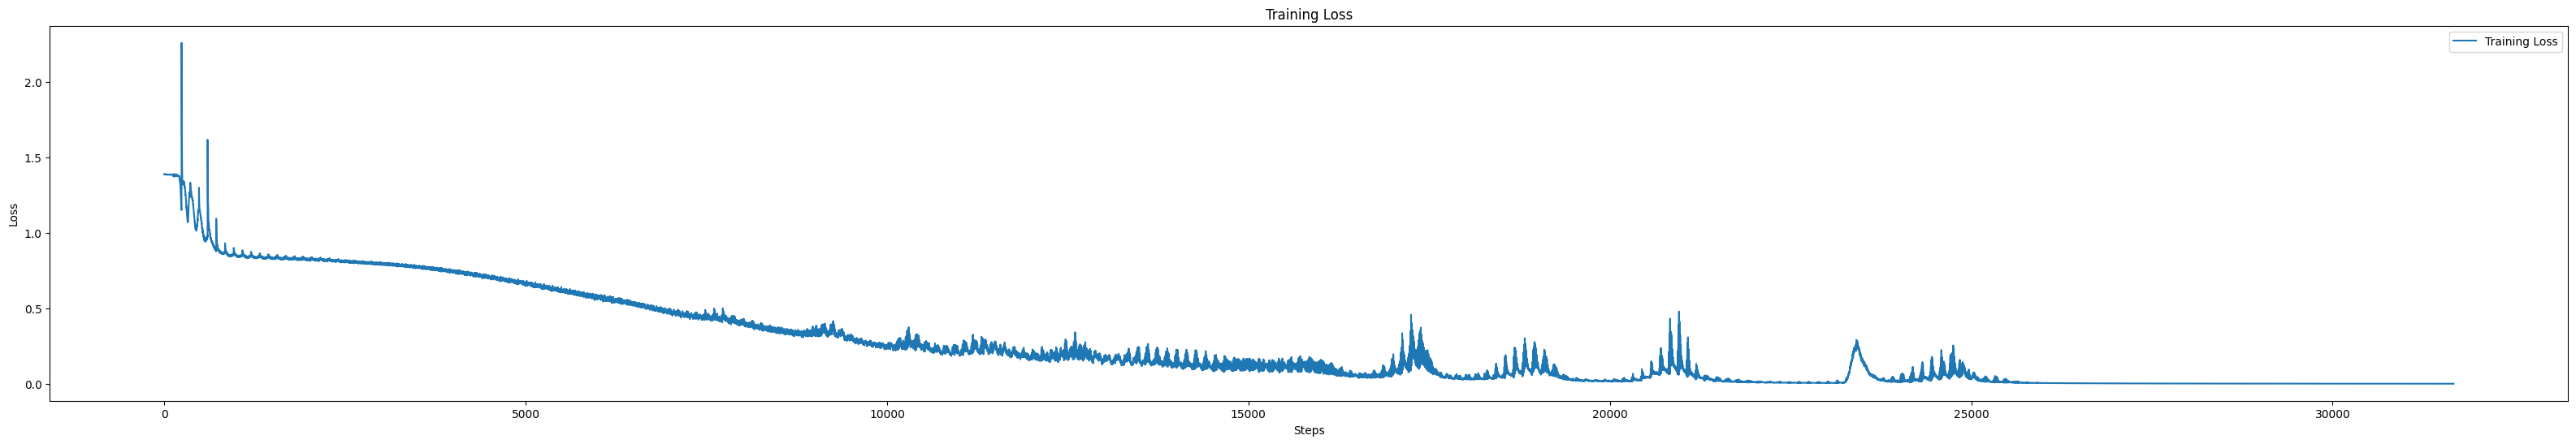

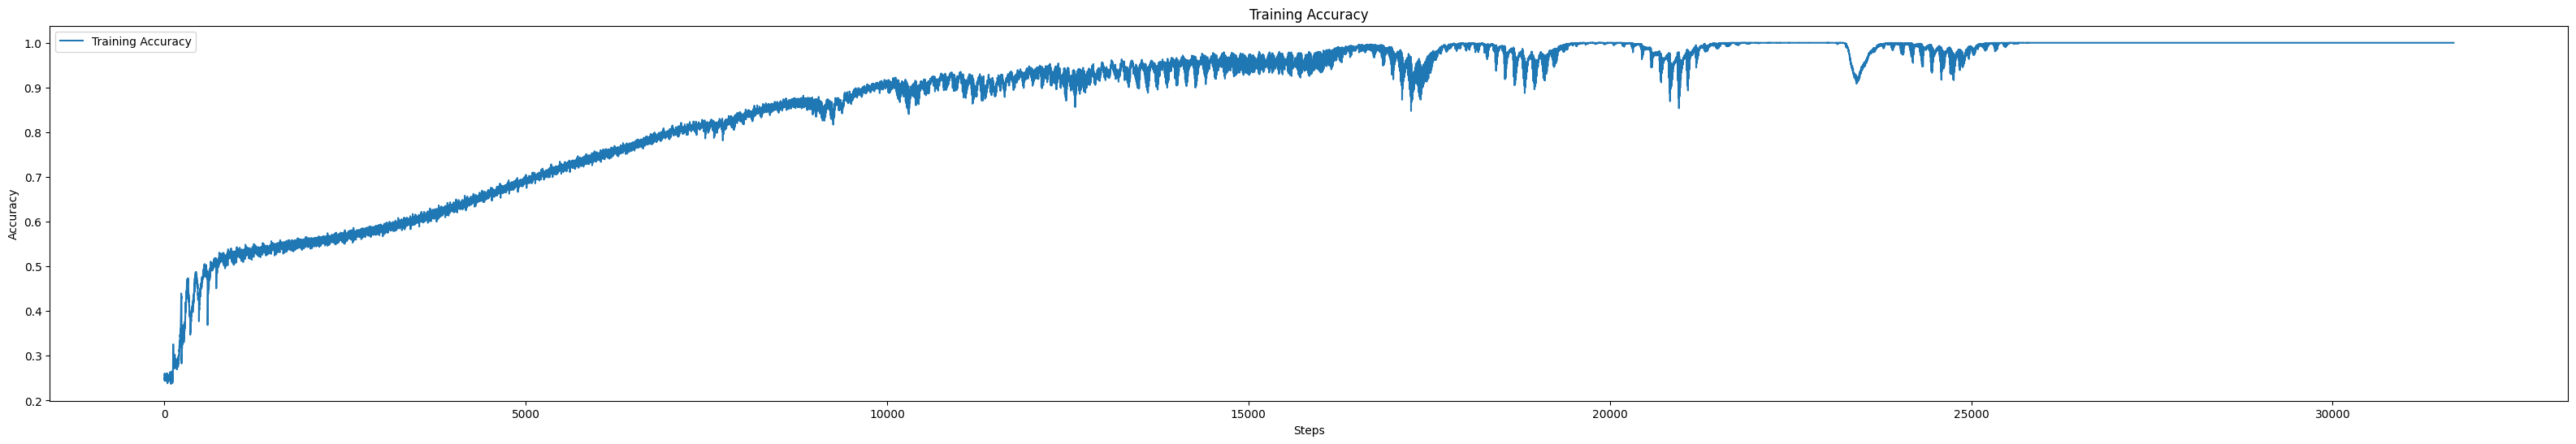

In [14]:
# Plot the loss curves
plt.figure(figsize=(40, 6))
plt.plot(losses, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

# Plot the accuracy curves
plt.figure(figsize=(40, 6))
plt.plot(accuracies, label="Training Accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()
plt.show()

In [18]:
# Generate Text Function
def generate_text(model, start_index, length):
    model.eval()
    generated_tokens = []
    indices = torch.arange(start_index, start_index + length).to(device)
    with torch.no_grad():
        outputs = model(indices)
        _, predicted = torch.max(outputs, 1)
    for id in predicted:
        token = id_to_token.get(id.item(), "<UNK>")
        generated_tokens.append(token)
    return ''.join(generated_tokens)

# Generate text starting from the next index after the training data
start_index = 0
generated_text = generate_text(model, start_index=start_index, length=100)
print("Generated Text:")
print(generated_text)

# Generate text starting from the next index after the training data
start_index = len(text) - 50
generated_text = generate_text(model, start_index=start_index, length=100)
print("Generated Text:")
before_end = generated_text[:50]
after_end = generated_text[50:]
print(f"{before_end}_{after_end}")

Generated Text:
|bbb|ccc|ccc|aaa|bbb|ccc|ccc|bbb|aaa|bbb|aaa|bbb|bbb|ccc|bbb|bbb|bbb|aaa|aaa|bbb|aaa|bbb|aaa|bbb|aaa
Generated Text:
cc|bbb|ccc|aaa|ccc|aaa|bbb|ccc|bbb|ccc|bbb|aaa|ccc_|cba|abb|ccc|ccb|ccc|ccc|abc|cbc|aca|abc|bba|baa|a


In [19]:
N = len(text) - 1

#see value before conditioning
generated_text = generate_text(model, start_index=N+1, length=150)
print("Original Text:")
print(generated_text) # "|a..."
print("")

#conditioning the model
conditioning_targets = ['|','a']  # Desired tokens at N+1 and N+2, this also works if you use "|b"
conditioning_positions = [N+1, N+2]
# conditioning_targets = ['c','a','b'] #show conditioning works on discontinuous tokens
# conditioning_positions = [N+2, N+7, N+12]

conditioning_target_indices = [token_to_id[token] for token in conditioning_targets]
targets_tensor = torch.tensor(conditioning_target_indices, dtype=torch.long).to(device)
positions_tensor = torch.tensor(conditioning_positions).to(device)

criterion = nn.CrossEntropyLoss()
conditioning_optimizer = optim.SGD(model.parameters(), lr=1e-3)
model.train()
step = 0

while True:
    conditioning_optimizer.zero_grad()
    outputs = model(positions_tensor)
    loss = criterion(outputs, targets_tensor)
    loss.backward()
    conditioning_optimizer.step()
    print(f"Conditioning Step {step+1}, Loss: {loss.item():.6f}")
    #get new outputs
    generated_tokens = []
    outputs = model(positions_tensor)
    predicted = torch.argmax(outputs, dim=1)
    for id in predicted:
        token = id_to_token.get(id.item(), "<UNK>")
        generated_tokens.append(token)
    print("".join(generated_tokens))
    if generated_tokens == conditioning_targets:
        break

#see value after conditioning
generated_text = generate_text(model, start_index=N+1, length=150)
print("")
print("Text after conditioning:")
print(generated_text) # "|ccc|..." shows conditioning works because of new values for N+3 and N+4

Original Text:
|cba|abb|ccc|ccb|ccc|ccc|abc|cbc|aca|abc|bba|baa|aac|cba|ccb|bab|bba|ccc|bbc|ccb|ccc|aaa|bba|ccc|bbb|cbb|aaa|ccc|cac|abb|bcc|aca|bbb|bac|caa|bab|ccb|c

Conditioning Step 1, Loss: 7.140614
|a

Text after conditioning:
|aaa|aab|ccc|ccb|bcc|ccc|abc|cbc|aca|abc|bba|baa|cac|cba|ccb|bab|bba|ccc|bbb|acb|ccc|aaa|bba|cca|bbb|cbb|aaa|ccc|bac|abb|acc|aca|cbb|bab|caa|bab|ccb|c


In [20]:
model, optimizer, losses = load_checkpoint(filename="checkpoint_rff.pth")

Checkpoint loaded: loss 0.0003


In [21]:
print(token_to_id)

{'a': 0, 'b': 1, 'c': 2, '|': 3}


In [22]:
#RFF version of this does not work well!

#assess performance of subsequent conditioning
random.seed(42)
options = ['|aaa','|bbb','|ccc']
sequences = options * 30
random.shuffle(sequences)
new_text = ''.join(sequences) #new text to condition on
print("target:")
print(new_text)


#now we'll condition the model, one letter at a time

criterion = nn.CrossEntropyLoss()
conditioning_optimizer = optim.SGD(model.parameters(), lr=1e-3)
model.train()
N = len(text)

for i, letter in enumerate(new_text):

    conditioning_optimizer.zero_grad()

    print("-"*50)

    idx = N + i
    print("conditioning on:")
    print(f"{"_"*i}{letter}{"_"*(len(new_text)-i-1)}")

    #see value before conditioning
    print("output before conditioning:")
    generated_text = generate_text(model, start_index=N, length=len(new_text))
    print(generated_text)

    while True:

        target_ids = [token_to_id[letter]]
        target_tensor = torch.tensor(target_ids, dtype=torch.long).to(device)
        positions = torch.tensor([idx]).to(device)
        outputs = model(positions)
        print(outputs)
        # print(outputs.shape)
        # print(target_tensor.shape)
        loss = criterion(outputs, target_tensor)
        loss.backward()
        conditioning_optimizer.step()
        print(f"Loss: {loss.item():.6f}")

        #see value after conditioning
        print("output after conditioning:")
        generated_text = generate_text(model, start_index=N, length=len(new_text))
        print(generated_text)

        predicted_letter = generated_text[i]
        print(f"{letter} -> {predicted_letter} ... {letter == predicted_letter}")
        if predicted_letter == letter:
            break    
        print('--')

target:
|bbb|bbb|aaa|bbb|aaa|aaa|aaa|ccc|bbb|ccc|aaa|ccc|bbb|bbb|ccc|bbb|ccc|bbb|aaa|ccc|bbb|bbb|bbb|aaa|aaa|ccc|bbb|ccc|aaa|bbb|bbb|ccc|aaa|bbb|bbb|ccc|aaa|aaa|ccc|aaa|ccc|ccc|bbb|bbb|bbb|bbb|ccc|bbb|ccc|ccc|bbb|aaa|aaa|ccc|aaa|aaa|aaa|bbb|aaa|ccc|aaa|ccc|ccc|ccc|aaa|ccc|aaa|aaa|ccc|ccc|bbb|bbb|bbb|ccc|aaa|ccc|aaa|bbb|aaa|aaa|ccc|aaa|bbb|ccc|bbb|bbb|ccc|aaa|ccc|aaa
--------------------------------------------------
conditioning on:
|_______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
output before conditioning:
|cba|abb|ccc|ccb|ccc|ccc|abc|cbc|aca|abc|bba|baa|aac|cba|ccb|bab|bba|ccc|bbc|ccb|ccc|aaa|bba|ccc|bbb|cbb|aaa|ccc|cac|abb|bcc|aca|bbb|bac|caa|bab|ccb|ccc|bbb|cab|ccc|cba|ccb|c